# Basic Statistics for Cosmology: Exercises on $H_0$

This notebook is designed as a **student exercise**.  
You will work through **Frequentist** and **Bayesian** methods to estimate the Hubble constant $H_0$ from mock data.  

👉 This is the **exercise version** (without solutions).  
The instructor has a separate notebook with solutions.

---

## Instructions
- Fill in the code cells where you see `# TODO`.
- Answer the discussion questions in markdown cells.
- Try to first attempt on your own before checking solutions.

---

## Doing SN cosmology with a synthetic dataset, using luminosity distance relation

**Key low-$z$ relations** (valid for $z\lesssim0.1$):

$$ d_L \approx \frac{cz}{H_0} \quad (\text{in Mpc}) $$
$$ \mu \equiv m - M = 5\log_{10}\!\left( \frac{d_L}{\text{Mpc}} \right) + 25 $$
Combining these: 
$$ m = M + 5\log_{10}(cz) - 5\log_{10}(H_0) + 25. $$

If $M$ is known (from external calibration), one can directly infer $H_0$. If $M$ is unknown **and** you only fit SN data, then $(M, H_0)$ are nearly perfectly degenerate at low $z$—you must supply an $M$ prior or external constraint to break the degeneracy.



## Part 1: Frequentist Statistics

### Exercise 1.1: Load and Visualize Data
Generate a very simplistic SN dataset!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple

c_km_s = 299792.458  # speed of light in km/s

def mu_from_z(z, H0):
    """Low-z luminosity distance modulus: mu = 5 log10(c z / H0 [Mpc]) + 25.
    Here c is in km/s, H0 in km/s/Mpc, so cz/H0 is in Mpc.
    """
    dL_Mpc = (c_km_s * z) / H0
    return 5.0 * np.log10(dL_Mpc) + 25.0

def mag_model(z, H0, M):
    return M + mu_from_z(z, H0)

def sigma_mu_pec(z, v_pec=300.0, H0=70.0):
    """Approximate magnitude uncertainty from peculiar velocities.
    sigma_mu ~ (5/ln(10)) * (sigma_dL/dL).
    At low z, dL ~ cz/H0, so fractional distance error from peculiar velocity sigma_v is ~ sigma_v/(cz).
    """
    frac = v_pec/(c_km_s * z)
    return (5/np.log(10)) * frac

@dataclass
class SNSample:
    """
    Generate a synthetic supernova sample for cosmological parameter estimation.

    Parameters
    ----------
    z : np.ndarray
        Array of redshifts of the supernovae.
    m : np.ndarray
        Array of observed magnitudes of the supernovae.
    sigma_m : np.ndarray
        Array of total magnitude uncertainties (measurement + intrinsic + peculiar velocity).
    name : str
        Str for the name of the sample (default is "synthetic").
    """
    z: np.ndarray
    m: np.ndarray
    sigma_m: np.ndarray
    name: str = "synthetic"

def best_fit_H0_given_M(sn: SNSample, M, H0_grid=np.linspace(50, 90, 801)):
    chi2_vals = np.array([chi2(H0, M, sn) for H0 in H0_grid])
    j = np.argmin(chi2_vals)
    return H0_grid[j], chi2_vals, H0_grid

def make_synthetic_sample(N=100, H0=73.0, M=-19.3, zmin=0.01, zmax=0.08,
                          sigma_meas=0.1, sigma_int=0.1, v_pec=300.0, rng=None) -> SNSample:
    """
    Generate a synthetic supernova sample for cosmological parameter estimation.

    Parameters
    ----------
    N : int
        Number of supernovae to simulate.
    H0 : float
        True Hubble constant (km/s/Mpc) used to generate the data.
    M : float
        True absolute magnitude of the supernovae.
    zmin : float
        Minimum redshift of the sample.
    zmax : float
        Maximum redshift of the sample.
    sigma_meas : float
        Measurement uncertainty in magnitudes (per SN).
    sigma_int : float
        Intrinsic scatter in magnitudes (per SN).
    v_pec : float
        RMS peculiar velocity in km/s (affects low-z distance errors).
    rng : int, np.random.Generator, or None
        Random seed or numpy random generator for reproducibility.

    Returns
    -------
    SNSample
        Dataclass containing arrays of redshift (z), observed magnitude (m), 
        total magnitude uncertainty (sigma_m), and sample name.
    """
    rng = np.random.default_rng(rng)
    z = np.sort(rng.uniform(zmin, zmax, size=N))
    mu = mu_from_z(z, H0)
    m_true = M + mu
    # per-SN error budget: measurement + peculiar velocity + intrinsic scatter
    sig_pec = sigma_mu_pec(z, v_pec=v_pec, H0=H0)
    sigma_tot = np.sqrt(sigma_meas**2 + sig_pec**2 + sigma_int**2)
    m_obs = rng.normal(m_true, sigma_tot)
    return SNSample(z=z, m=m_obs, sigma_m=sigma_tot, name="synthetic")

In [2]:
N=100
H0=73.0
M=-19.3
zmin=0.01
zmax=0.08,
sigma_meas=0.1,
sigma_int=0.1,
v_pec=300.0

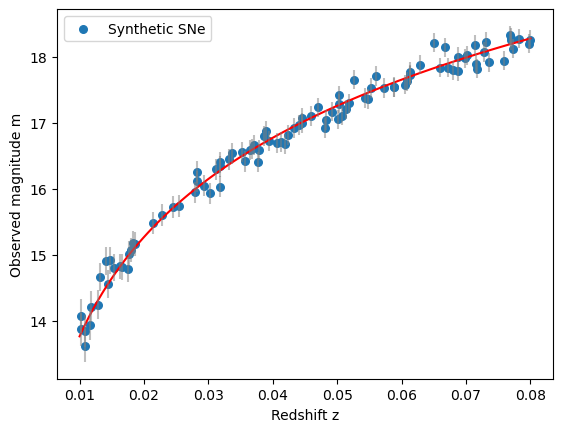

In [3]:
# TODO: generate and plot data with error bars
data = make_synthetic_sample()
z_list = np.linspace(zmin, zmax, len(data.z))
model = mag_model(z_list , H0, M)


plt.figure()
plt.scatter(data.z,data.m, s=30, label='Synthetic SNe')
plt.plot(z_list, model, c= 'red')
plt.errorbar(data.z,data.m, yerr=data.sigma_m, fmt='none', ecolor='gray', alpha=0.5)
plt.xlabel('Redshift z')
plt.ylabel('Observed magnitude m')
plt.legend()
plt.show()


### Exercise 1.2: Define the χ² function
Write down the chi-square function for the model.

In [4]:
# TODO: define chi2 function
def chi2(theta, x, y, sigma, M):
    y_t = mag_model(x, theta, M)
    return np.sum( ((y-y_t)/sigma)**2)

### Exercise 1.3: Minimize χ²
Find the best-fit parameters by minimizing χ².

In [5]:
# TODO: use numpy or scipy to minimize chi2
# best_fit of H0 = ...

H0_list = np.linspace(60, 80, 1000)

def best_fit_H0_given_M(data, M, H0_grid):
    chi2_list = [chi2(H, data.z, data.m, data.sigma_m, M) for H in H0_list]
    return H0_list[np.argmin(chi2_list)], chi2_list, H0_grid
    
best_fit = best_fit_H0_given_M(data, M, H0_list)[0]
chi2_list = best_fit_H0_given_M(data, M, H0_list)[1]

/tmp/ipykernel_6667/3646302156.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


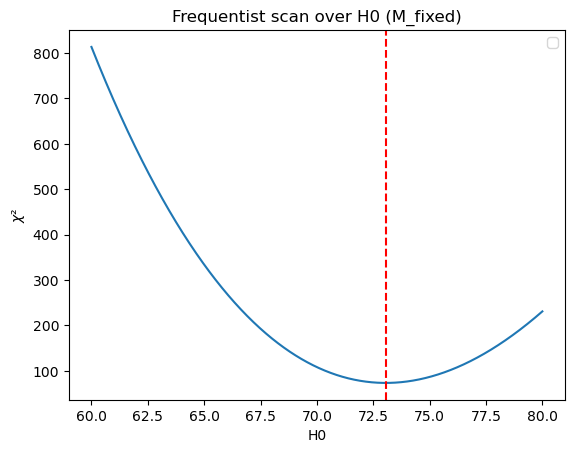

In [6]:
# TODO: say something about goodness of fit

plt.figure()
plt.plot(H0_list, chi2_list)
plt.xlabel('H0')
plt.ylabel(r'$\chi²$')
plt.axvline(best_fit, c= 'red', linestyle='--')
plt.legend()
plt.title("Frequentist scan over H0 (M_fixed)")
plt.show()

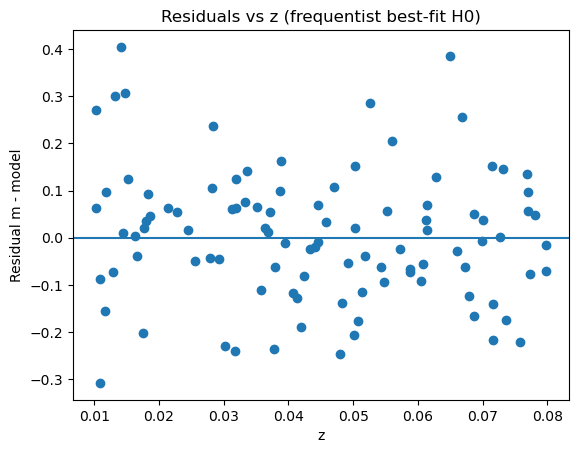

In [7]:
# TODO: plot residuals, always!

residual = data.m - mag_model(data.z, best_fit, M)

plt.figure()
plt.scatter(data.z, residual)

plt.axhline(0, linestyle='-')
plt.ylabel('Residual m - model')
plt.xlabel('z')
plt.title("Residuals vs z (frequentist best-fit H0)")
plt.show()

### Exercise 1.4: Bootstrap uncertainties
Use bootstrap resampling to estimate parameter uncertainties.

In [8]:
def bootstrap_H0(sn: SNSample, M, nboot=500, rng=None):
    """
    Estimate the uncertainty in H0 by bootstrapping the SN sample.

    Parameters
    ----------
    sn : SNSample
        The supernova sample (with z, m, sigma_m arrays).
    M : float
        The assumed absolute magnitude of the supernovae.
    nboot : int, optional
        Number of bootstrap resamples (default: 500).
    rng : np.random.Generator or None, optional
        Random number generator or seed (default: None).

    Returns
    -------
    np.ndarray
        Array of best-fit H0 values from each bootstrap resample.
    """
    rng = np.random.default_rng(rng)
    H0s = []
    idx = np.arange(len(sn.z))
    H0_grid = np.linspace(50, 90, 801) # same grid as before
    for _ in range(nboot):
        # Resample SN indices with replacement
        sel = rng.choice(idx, size=len(idx), replace=True)
        # Create a new SNSample with the resampled data
        sn_b = SNSample(sn.z[sel], sn.m[sel], sn.sigma_m[sel], name=sn.name)
        # Find best-fit H0 for this resample
        hbest, chi2_vals, Hg = best_fit_H0_given_M(sn_b, M, H0_grid=H0_grid)
        H0s.append(hbest)
    return np.array(H0s)

In [9]:
# TODO: implement bootstrap loop, any ideas how to do this?

# The concept is to resample the data with replacement, fit each resampled dataset, and collect the best-fit parameters to estimate uncertainties.

H0_boot = bootstrap_H0(data, M, nboot=2000)

Bootstrap median H0 = 73.05 km/s/Mpc
Bootstrap 68% interval: [72.61, 73.50] km/s/Mpc


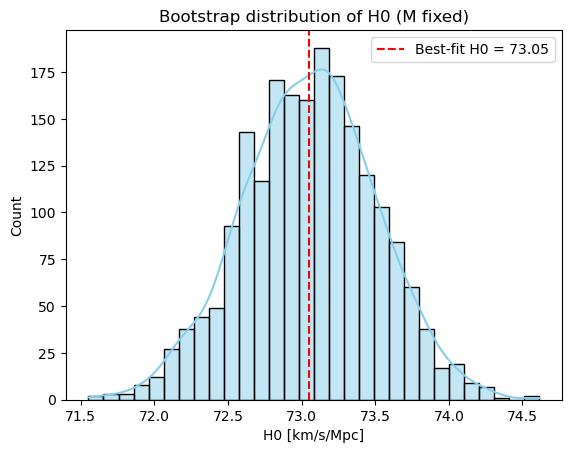

In [10]:
import seaborn as sns

h_med = np.median(H0_boot)
h_lo, h_hi = np.percentile(H0_boot, [16, 84])
print(f"Bootstrap median H0 = {h_med:.2f} km/s/Mpc")
print(f"Bootstrap 68% interval: [{h_lo:.2f}, {h_hi:.2f}] km/s/Mpc")

plt.figure()
sns.histplot(H0_boot, bins=30, kde=True, stat="count", color="skyblue", edgecolor="k")
plt.axvline(best_fit, color='r', linestyle='--', label=f'Best-fit H0 = {best_fit:.2f}')
plt.xlabel('H0 [km/s/Mpc]')
plt.ylabel('Count')
plt.title('Bootstrap distribution of H0 (M fixed)')
plt.legend()
plt.show()

### Exercise 1.5: p-value
Calculate a p-value from the sampled probability

In [17]:
# TODO: let's calculate a p-value from the sampled probability

### Exercise 1.6: Compare with MLE
Explain how minimizing χ² relates to Maximum Likelihood Estimation.

---
Frequentist MLE: joint fit of $(H_0, M)$ with an external calibrator

SN-only data at low $z$ cannot separately determine $H_0$ and $M$; they are (almost) perfectly degenerate. In a frequentist setting, we can include an **external calibrator measurement** of $M$ via a Gaussian constraint (a.k.a. penalty term) and then do **maximum likelihood estimation (MLE)** jointly for $(H_0, M)$.

We minimize
$$ -2\ln\mathcal{L}(H_0, M) = \chi^2_\mathrm{SN}(H_0, M) + \frac{(M-M_\mathrm{cal})^2}{\sigma_M^2}. $$

From the MLE, we compute the **covariance** and **correlation** matrices using a numerical Hessian approximation to the observed Fisher information.

In [ ]:
H0_grid = np.linspace(68, 78, 1000)
M_grid = np.linspace(-19.6, -19, 1000)

def log_likelihood_function(H0, M, x, y, sigma, M_cal=-19.3, M_sigma=0.05):
    L = chi2(H0, x, y, sigma, M) + (M - M_cal)**2/M_sigma**2
    return -0.5*L

def best_fit_given_2D(data, M_grid, H0_grid, M_cal=-19.3, M_sigma=0.05):
    L_grid = np.zeros((len(H0_grid),len(M_grid)))
    for i in range(len(M_grid)):
        for j in range(len(H0_grid)):
            L_grid[i,j]=log_likelihood_function(H0_grid[j], M_grid[i], data.z, data.m, data.sigma_m, M_cal=-19.3, M_sigma=0.05)

    return L_grid

L_grid = best_fit_given_2D(data, M_grid, H0_grid)



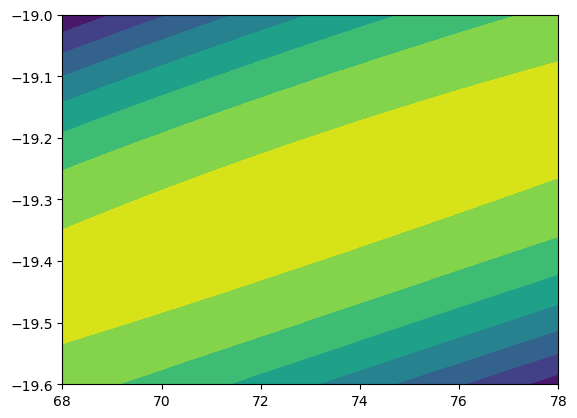

In [52]:
plt.figure()
plt.contourf(H0_grid, M_grid, L_grid)
# plt.
plt.show()

## Part 2: Bayesian Statistics

### Exercise 2.1: Bayes' theorem
Write Bayes' theorem and identify prior, likelihood, posterior.

👉 *Write Bayes' theorem in your own words here*

### Exercise 2.2: Compute Posterior on a Grid
Define priors and likelihood, then compute posterior on a parameter grid.

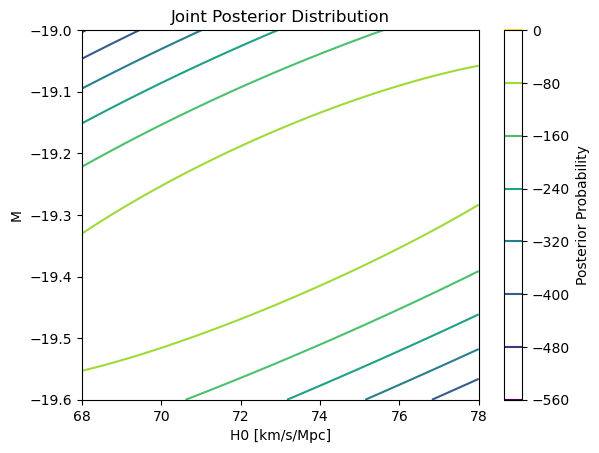

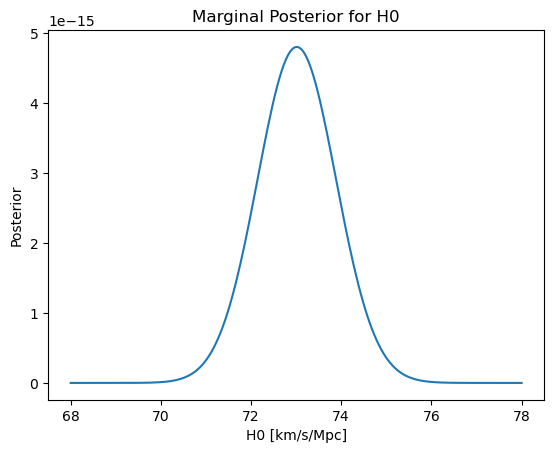

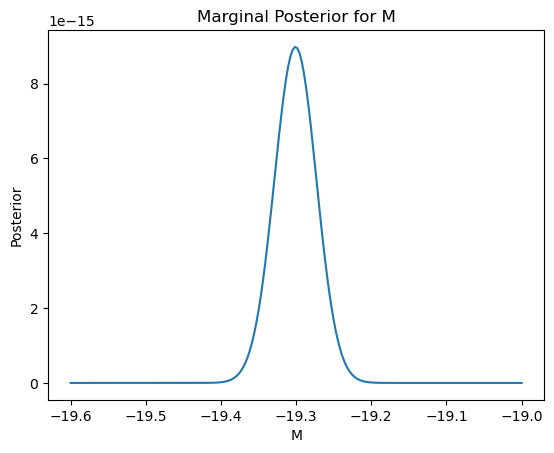

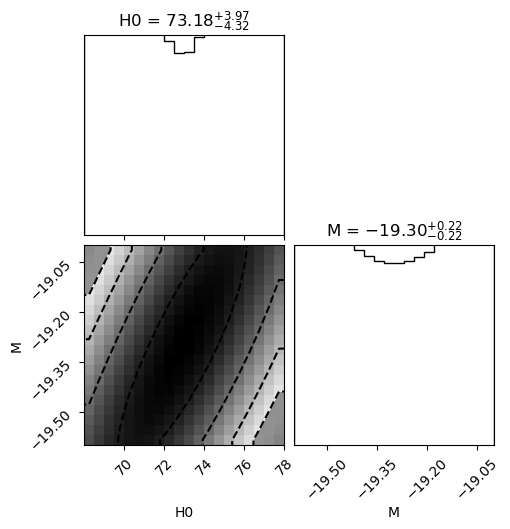

In [86]:
#  Gaussian priors for H0 and M
import corner

H0_grid = np.linspace(68, 78, 200)
M_grid = np.linspace(-19.6, -19.0, 200)

H0_mesh, M_mesh = np.meshgrid(H0_grid, M_grid)

def log_likelihood(theta, x, y, sigma):
    H0, M = theta
    model = mag_model(x, H0, M)
    return -0.5 * np.sum(((y - model) / sigma) ** 2)

log_likelihood_values = np.array([[log_likelihood((H0, M), data.z, data.m, data.sigma_m)
                                    for H0 in H0_grid] for M in M_grid])


H0_mu, H0_sigma = 73.0, 1.0     # example prior for H0
M_mu, M_sigma = -19.3, 0.05      # example prior for M

def log_prior(H0, M):
    lp_H0 = -0.5 * ((H0 - H0_mu)/H0_sigma)**2 - np.log(H0_sigma*np.sqrt(2*np.pi))
    lp_M  = -0.5 * ((M - M_mu)/M_sigma)**2   - np.log(M_sigma*np.sqrt(2*np.pi))
    return lp_H0 + lp_M

# Compute log-posterior grid
log_posterior_values = np.zeros_like(log_likelihood_values)

for i, M in enumerate(M_grid):
    for j, H0 in enumerate(H0_grid):
        log_posterior_values[i, j] = log_likelihood_values[i, j] + log_prior(H0, M)


posterior = log_posterior_values

# Marginalize to get 1D posteriors
posterior_H0 = np.sum(np.exp(posterior), axis=0)   # sum over M
posterior_M  = np.sum(np.exp(posterior), axis=1)   # sum over H0


# Joint posterior
plt.figure()
plt.contour(H0_grid, M_grid, posterior, levels=6, cmap='viridis')
plt.colorbar(label='Posterior Probability')
plt.xlabel('H0 [km/s/Mpc]')
plt.ylabel('M')
plt.title('Joint Posterior Distribution')
plt.show()

#  H0
plt.figure()
plt.plot(H0_grid, posterior_H0)
plt.xlabel('H0 [km/s/Mpc]')
plt.ylabel('Posterior')
plt.title('Marginal Posterior for H0')
plt.show()

#  M
plt.figure()
plt.plot(M_grid, posterior_M)
plt.xlabel('M')
plt.ylabel('Posterior')
plt.title('Marginal Posterior for M')
plt.show()


# matplotlib corner plot
import corner
samples = np.array(np.meshgrid(H0_grid, M_grid)).T.reshape(-1, 2)
weights = posterior.flatten()
fig = corner.corner(samples, weights=weights, labels=['H0', 'M'], show_titles=True)
plt.show()



### Exercise 2.3: Normalize Posterior and Extract Marginal Estimates
Normalize posterior, compute marginal estimations of $H_0$ and $M$

In [1]:
# TODO: normalize posterior
# TODO: compute marginal distributions

### Exercise 2.4: Credible Interval
Compute the 68% credible interval from the posterior.

In [ ]:
# TODO: credible interval calculation

### Exercise 2.5: Compare with Frequentist Result
Compare Bayesian and Frequentist estimates of $H_0$.

👉 *Write your comparison here*

## Part 3: Re-do with `Cobaya`

Estimate $H_0$ using Cobaya and Bayesian Statistics and compare

In [70]:
import cobaya

In [87]:
# get 3 plots : likelihood, posterior, corner

def chi2(H0, M, data):
    model = mag_model(data.z, H0, M)
    return np.sum(((data.m - model)/data.sigma_m)**2)

def loglike_cobaya(H0,M):
    return -0.5*chi2(H0,M,data)

info_dict = {
    "params": {
        "H0": {"prior": {"min": 50, "max": 90}, "ref": 73.0, "latex": r"$H_0$"},
        "M": {"prior": {"dist" : "norm", "loc": -19.3, "scale": 0.05},"latex": r"$M$"},
    },
    "likelihood": {
        "my_likelihood": {
            "external": loglike_cobaya
        }
    },
    "sampler": {
        "mcmc": {
            "max_tries": 10000,
            "Rminus1_stop": 0.01,
        }
    },
}

In [88]:
info, sampler = cobaya.run(info_dict)

[my_likelihood] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[prior] Reference values or pdfs for some parameters were not provided. Sampling from the prior instead for those parameters.
[mcmc] Initial point: H0:73, M:-19.36487
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {my_likelihood: 33500.0}
[prior] *WARNING* Reference pdf not defined or improper for some parameters. Using prior's sigma instead for them.
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Sampling!
[mcmc] Progress @ 2025-08-28 19:07:04 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 80 samples accepted.
[mcmc]  - Acceptance rate: 0.070
[mcmc]  - Convergence of means: R-1 = 3.041376 after 64 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 16

[mcmc] *WARNING* When combining chains, it is recommended to remove some initial fraction, e.g. 'skip_samples=0.3'
[root] *WARNING* outlier fraction 0.05661764705882353 
Mean:
[ 72.82558821 -19.30658207]
Covariance matrix:
[[3.66595816e+00 9.74370441e-02]
 [9.74370441e-02 2.83459840e-03]]


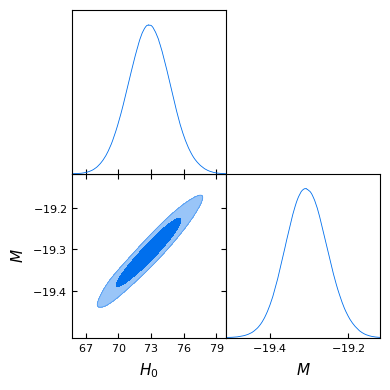

In [89]:
# Export the results to GetDist
gd_sample = sampler.products(to_getdist=True)["sample"]

# Analyze and plot
mean = gd_sample.getMeans()[:2]
covmat = gd_sample.getCovMat().matrix[:2, :2]
print("Mean:")
print(mean)
print("Covariance matrix:")
print(covmat)
# %matplotlib inline  # uncomment if running from the Jupyter notebook
import getdist.plots as gdplt

gdplot = gdplt.get_subplot_plotter()
gdplot.triangle_plot(gd_sample, ["H0", "M"], filled=True)